In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

In [2]:
!ls /home/chansingh/mntv1

anli_rough		single_query_anli_9_13	suffix_anli_9_12
embedded-ngrams		single_query_math_9_12	suffix_anli_9_13
projects		single_query_math_9_13	suffix_math_9_12
single_query_anli_9_12	single_query_rough	suffix_math_9_13


Load results

In [2]:
# dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_12'
# dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_13'
dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_14'
r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


# dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_12' #/home/chansingh/mntv1/sweep_morning2'
# dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_13' #/home/chansingh/mntv1/sweep_morning2'
dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_14' #/home/chansingh/mntv1/sweep_morning2'
r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

r = pd.concat((r_single_query, r_suffix_search)).sort_values('checkpoint')

FileNotFoundError: [Errno 2] No such file or directory: '/home/chansingh/mntv1/single_query_anli_9_14'

Plot relevant results

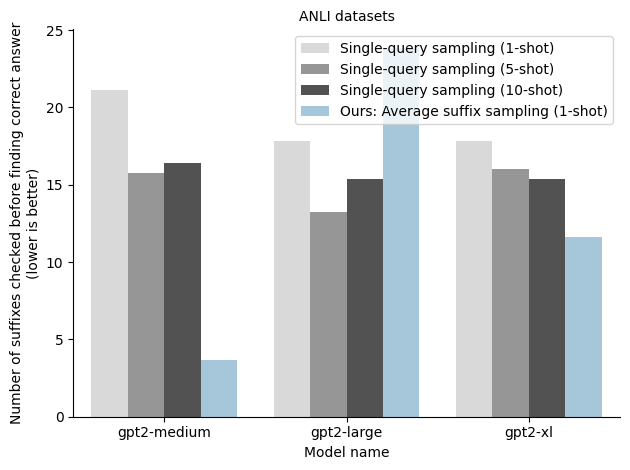

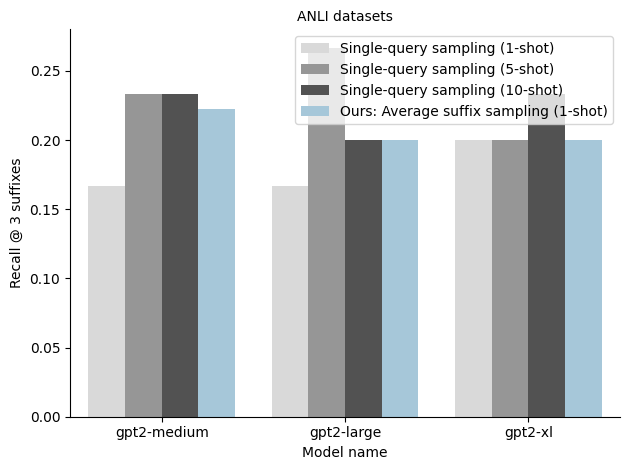

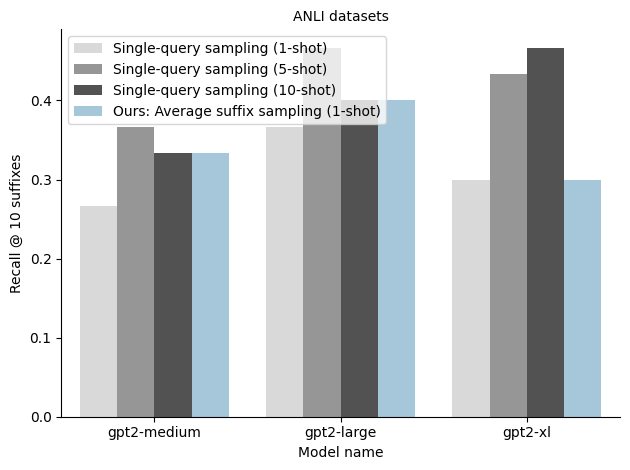

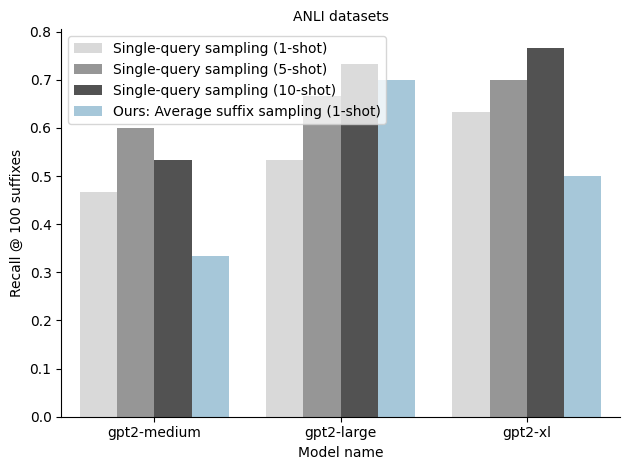

In [86]:
for metric_key in ['final_num_suffixes_checked',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {100} suffixes', ]:
    tab = analyze_utils.num_suffixes_checked_tab(r, metric_key=metric_key)
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets')


## Performance breakdowns

In [41]:
# cols_to_view = r_single_query.columns # cols_to_view
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(['checkpoint', 'n_shots', 'use_single_query', 'task_name'])[cols_to_view].mean().round(2)
    display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)

final_model_queries  \
checkpoint  n_shots use_single_query task_name                                                                 
gpt2-large  1       0                task088_identify_typo_verification                                  NaN   
                                     task1149_item_check_edible                                          NaN   
                                     task183_rhyme_generation                                            NaN   
                    1                task088_identify_typo_verification                                  NaN   
                                     task1149_item_check_edible                                          NaN   
                                     task1336_peixian_equity_evaluation_corpus_gende...                 23.0   
                                     task1509_evalution_antonyms                                         NaN   
                                     task183_rhyme_generation                                            NaN   
            5       1                task088_identify_typo_verification                                 37.0   
                                     task1149_item_check_edible                                          NaN   
                                     task1336_peixian_equity_evaluation_corpus_gende...                  8.0   
                                     task183_rhyme_generation                                            NaN   
            10      1                task1149_item_check_edible                                          NaN   
                                     task1336_peixian_equity_evaluation_corpus_gende...                  8.0   
                                     task183_rhyme_generation                                            NaN   
gpt2-medium 1       0                task088_identify_typo_verification                                  NaN   
                                     task092_check_prime_classification                                  NaN   
                                     task1149_item_check_edible                                          NaN   
                                     task1336_peixian_equity_evaluation_corpus_gende...                  NaN   
                                     task1509_evalution_antonyms                                         NaN   
                                     task183_rhyme_generation                                            NaN   
                    1                task088_identify_typo_verification                                  NaN   
                                     task092_check_prime_classification                                  NaN   
                                     task107_splash_question_to_sql                                     68.5   
                                     task1149_item_check_edible                                        101.0   
                                     task1336_peixian_equity_evaluation_corpus_gende...                 17.0   
                                     task1509_evalution_antonyms                                        42.0   
                                     task183_rhyme_generation                                            NaN   
            5       1                task088_identify_typo_verification                                 76.0   
                                     task092_check_prime_classification                                  NaN   
                                     task1149_item_check_edible                                          NaN   
                                     task1509_evalution_antonyms                                        42.0   
                                     task183_rhyme_generation                                            NaN   
            10      1                task088_identify_typo_verification                                101.0   
                                     task092_check_prime_